In [174]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn

<span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data

In [4]:
# load root file

infile_name = 'TB_FIRE_1101_hits.root'
infile = uproot.open(infile_name)

# get headings

keys = infile.keys()
print(keys)

hits = infile['Hits']
hits.show()

# sort all the characteristics of the run in arrays
tlu = hits['TLU_number'].array()
amp = hits['amplitude'].array()
toa = hits['toa'].array()
time = hits['timestamp'].array()
plane = hits['plane_ID'].array()
channel = hits['ch_ID'].array()


['Hits;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
TLU_number           | uint64_t                 | AsDtype('>u8')
timestamp            | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), he...
plane_ID             | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
ch_ID                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
amplitude            | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
toa                  | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...


In [ ]:
# create data of paramaters for each hit in the run

tlu_number = -1 # TLU is the event number in the run

# some printing to make sure that the zip works right for the arrays of all runs
# print(("plane:",plane[tlu_number],"ch",channel[tlu_number], " amp",amp[tlu_number]))
# print("######################")
# print("plane:", plane,"ch", channel, "amp", amp)
# print("##################")


hit_data_single_event = ak.zip({"plane":plane[tlu_number],"ch":channel[tlu_number], "amp":amp[tlu_number]})
hit_data = ak.zip({ "plane":plane, "ch":channel, "amp":amp})
# hit_data = ak.zip([amp[10], plane[10], channel[10]])


hit_data_single_event.show()
print("############")
hit_data.show()
type(hit_data)

[{plane: 5, ch: 164, amp: 29},
 {plane: 5, ch: 185, amp: 67}]
############
[[{plane: 0, ch: 128, amp: 39}, {...}, ..., {plane: 7, ch: 164, amp: 155}],
 [{plane: 0, ch: 126, amp: 13}, {...}, ..., {plane: 6, ch: 184, amp: 28}],
 [{plane: 0, ch: 166, amp: 17}, {...}, ..., {plane: 7, ch: 186, amp: 89}],
 [{plane: 0, ch: 164, amp: 87}, {...}, ..., {plane: 7, ch: 184, amp: 130}],
 [{plane: 0, ch: 102, amp: 50}, {...}, ..., {plane: 7, ch: 163, amp: 83}],
 [{plane: 0, ch: 120, amp: 21}, {...}, ..., {plane: 7, ch: 165, amp: 230}],
 [{plane: 0, ch: 105, amp: 52}, {...}, ..., {plane: 7, ch: 145, amp: 168}],
 [{plane: 0, ch: 144, amp: 12}, {...}, ..., {plane: 7, ch: 167, amp: 23}],
 [{plane: 0, ch: 125, amp: 35}, {...}, ..., {plane: 7, ch: 166, amp: 117}],
 [{plane: 0, ch: 87, amp: 17}, {...}, ..., {...}, {plane: 7, ch: 145, amp: 32}],
 ...,
 [{plane: 5, ch: 169, amp: 21}, {...}, ..., {plane: 6, ch: 183, amp: 248}],
 [{plane: 5, ch: 28, amp: 164}, {...}, ..., {plane: 6, ch: 203, amp: 16}],
 [{plan

awkward.highlevel.Array

In [ ]:
# Narrow down to the specific planes and channels
hits_plane_7 = hit_data[hit_data.plane == 7]
hits_plane_7.show()


[[{plane: 7, ch: 164, amp: 155}],
 [],
 [{plane: 7, ch: 186, amp: 89}],
 [{plane: 7, ch: 164, amp: 184}, {plane: 7, ch: 184, amp: 130}],
 [{plane: 7, ch: 163, amp: 83}],
 [{plane: 7, ch: 146, amp: 13}, {plane: 7, ch: 165, amp: 230}],
 [{plane: 7, ch: 145, amp: 168}],
 [{plane: 7, ch: 144, amp: 60}, {...}, ..., {plane: 7, ch: 167, amp: 23}],
 [{plane: 7, ch: 166, amp: 117}],
 [{plane: 7, ch: 145, amp: 32}],
 ...,
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]


<Array [[164], [], [186], [...], ..., [], [], []] type='2356797 * var * int32'>

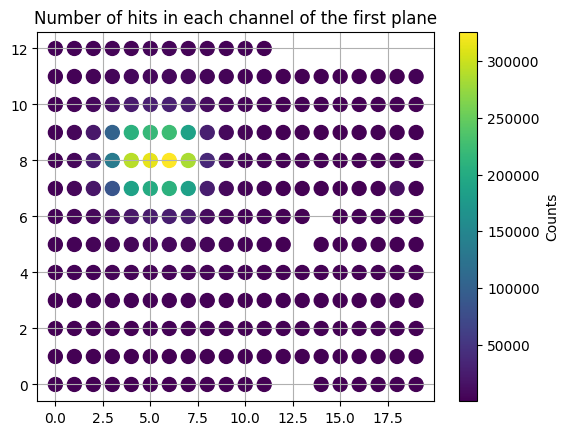

In [175]:
# Show the amount of hits on a colormap

# define the array of channels activated on a certain plane
# plane_7_ch = hits_plane_7.ch
plane_7_ch = hits_plane_7.ch[ak.num(hits_plane_7.ch) > 0]



# Convert awkward array to NumPy array
# data_np = ak.to_numpy(ak.flatten(plane_7_ch))


# Use np.unique to get unique rows and counts
unique_points, counts = np.unique(ak.flatten(plane_7_ch), axis=0, return_counts=True)


# give each pad a 2d coordinates on the sensors plane
# divmod(ch,20) = (y,x) gives the quotient as the row(y) and remainder as the column(x) of a channel on the plane

plane_7_ch_2d = divmod(unique_points, 20)


x_vals = plane_7_ch_2d[1]
y_vals = plane_7_ch_2d[0]


# plot the colormap
plt.scatter(x_vals, y_vals, c=counts,  s=100)
# plt.scatter(x_vals, y_vals, c=counts, cmap='viridis', s=100)
plt.colorbar(label='Counts')
plt.title('Number of hits in each channel of the first plane')
plt.grid()
plt.show()

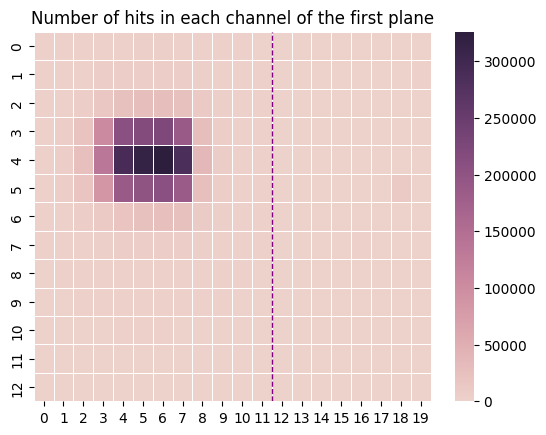

In [ ]:
# convert the data into a matrix of 12x20
counts_matrix = np.zeros((13, 20))
for i in range(len(unique_points)):
    q = plane_7_ch_2d[0][i] # quotinent
    r = plane_7_ch_2d[1][i] # remainder
    counts_matrix[-1-q][r] = counts[i]


task = [0,1,2,3,4,5,6,7,8,9,10,11,0,1,2,3,4,5,6,7]
seaborn.heatmap(counts_matrix, cmap=seaborn.cubehelix_palette(as_cmap=True), linewidths=0.5)
plt.title('Number of Hits in each channel in the first plane')
plt.axvline(x=12, color='purple', linestyle='--', linewidth=1)